In [49]:
import pandas as pd
sdel=pd.read_excel("Сделки_2025-11-25.xlsx")

In [50]:
proj=pd.read_excel("Проектные данные_2025-11-25.xlsx")

In [51]:
print(sdel.columns)
print(proj.columns)

Index(['Название региона', 'Город', 'Район', 'Округ', 'Класс',
       'Конструкция объекта', 'Застройщик', 'Название ЖК', 'Адрес корпуса',
       'ID корпуса', 'Текущая стадия строительства', 'Дата начала продаж',
       'Дата ввода в эксплуатацию', 'Дата договора (месяц.год)',
       'Дата регистрации (месяц.год)', 'Уступка',
       'Суммарное количество сделок', 'Тип лота', 'Этаж лота',
       'Количество комнат', 'Суммарная площадь сделок', 'Сумма бюджета',
       'Скидка', 'Внутренняя отделка', 'Продавец', 'Покупатель', 'Ипотека',
       'Название банка'],
      dtype='object')
Index(['ID корпуса', 'Проект', 'Класс проекта', 'Девелопер', 'Конструкця дома',
       'Этажей от', 'Этожей до', 'Адрес', 'Плановая дата РВЭ',
       'Стадия строительства', 'Тип договора реализации',
       'Тип объекта недвижимости', 'Этаж', 'Кол-во комнат',
       'Общая проектная площадь', 'Количество лотов'],
      dtype='object')


In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Настройки
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 8) # Высокие вертикальные графики
pd.set_option('display.float_format', '{:,.2f}'.format)

# --- 1. ФУНКЦИЯ ОЧИСТКИ (без изменений логики, только применение) ---
def clean_numeric_col(df, col_name):
    if col_name in df.columns:
        val = df[col_name].astype(str)
        val = val.str.replace("\u00a0", "").str.replace(" ", "").str.replace(",", ".")
        return pd.to_numeric(val, errors="coerce").fillna(0)
    return df[col_name] if col_name in df.columns else 0

# Очищаем сделки
numeric_cols = ['Сумма бюджета', 'Суммарная площадь сделок', 
                'Суммарное количество сделок', 'Этаж лота', 'Количество комнат']
for col in numeric_cols:
    sdel[col] = clean_numeric_col(sdel, col)

# Очищаем проекты (для проверки этажности)
proj_cols = ['Этажей до', 'Общая проектная площадь']
for col in proj_cols:
    proj[col] = clean_numeric_col(proj, col)

# --- 2. РАСЧЕТ УДЕЛЬНЫХ МЕТРИК (ДЛЯ ОДНОГО ЛОТА) ---
# Защита от деления на ноль: если сделок 0, считаем как 1 (чтобы не потерять строку, хотя это странно)
sdel['cnt_safe'] = sdel['Суммарное количество сделок'].replace(0, 1)

# Реальная цена ОДНОЙ квартиры = Общий бюджет строки / Кол-во сделок
sdel['Unit_Price'] = sdel['Сумма бюджета'] / sdel['cnt_safe']

# Реальная площадь ОДНОЙ квартиры
sdel['Unit_Area'] = sdel['Суммарная площадь сделок'] / sdel['cnt_safe']

# Цена за метр (Бюджет / Площадь) - тут делить на кол-во сделок не надо, пропорция сохраняется
sdel['Price_m2'] = sdel['Сумма бюджета'] / sdel['Суммарная площадь сделок'].replace(0, np.nan)

# --- 3. РАЗМНОЖЕНИЕ СТРОК (EXPANSION) ---
# Это ключевой момент. Если в строке 5 сделок, мы превращаем её в 5 строк для графиков.
# Используем np.repeat для индексов
print(f"Строк до разгруппировки: {len(sdel)}")

# Повторяем индексы столько раз, сколько указано в 'Суммарное количество сделок'
# Ограничим .astype(int), чтобы убедиться, что это целые числа
counts = sdel['Суммарное количество сделок'].fillna(1).astype(int)
expanded_indices = np.repeat(sdel.index, counts)

# Создаем новый "тяжелый" датафрейм, отражающий реальное кол-во проданных лотов
sdel_expanded = sdel.loc[expanded_indices].copy()

print(f"Строк после разгруппировки (Реальное кол-во сделок): {len(sdel_expanded)}")
print("Готово к анализу.")

Строк до разгруппировки: 50955
Строк после разгруппировки (Реальное кол-во сделок): 51832
Готово к анализу.


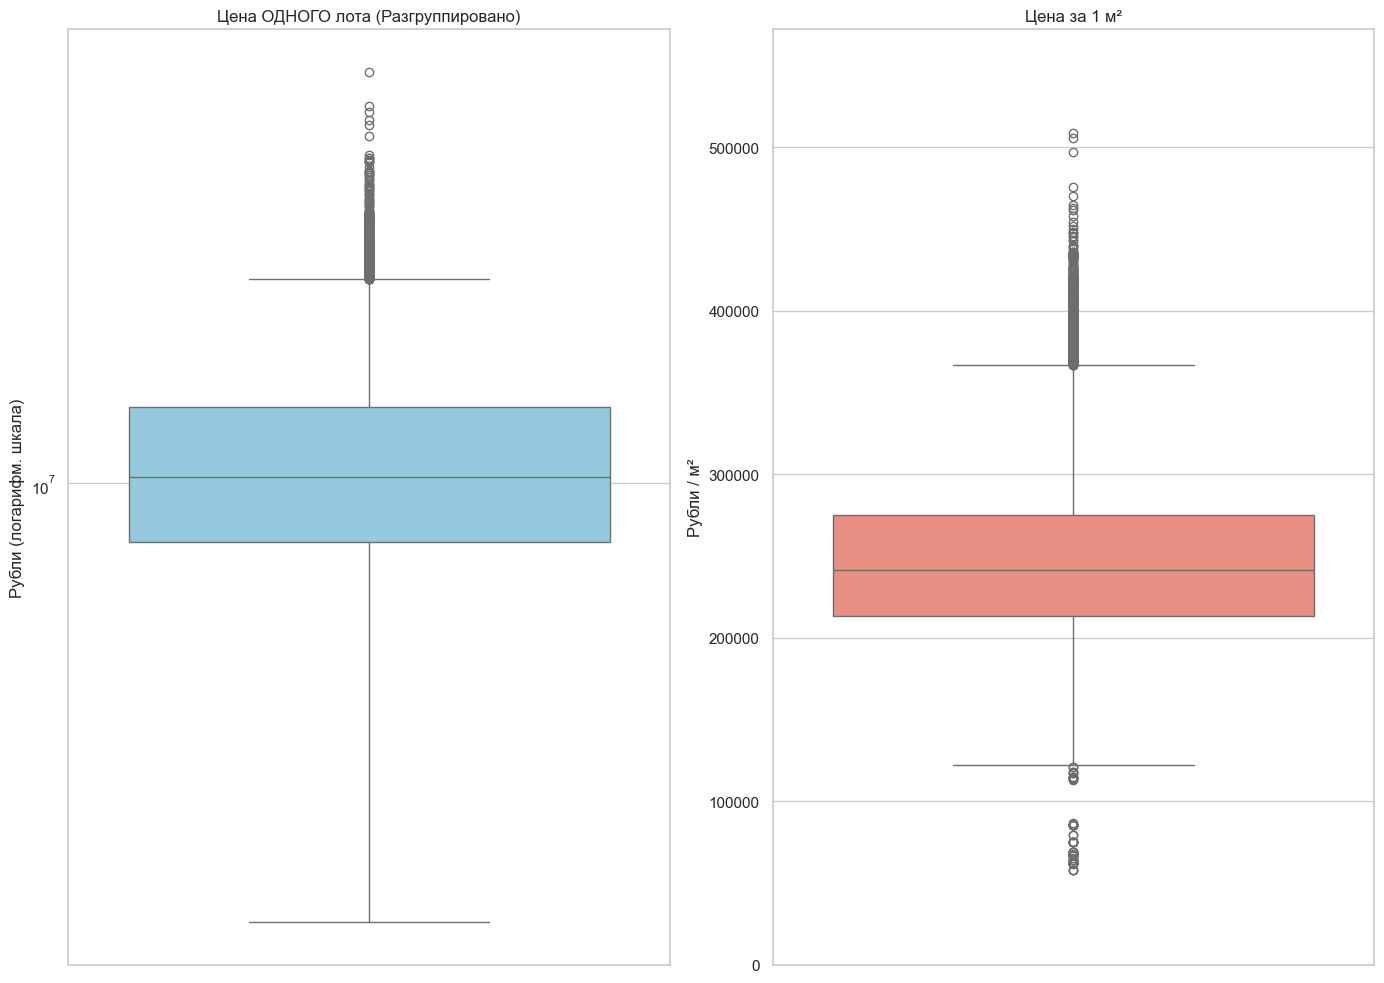

=== АНОМАЛИИ ===
Лотов дешевле 1 млн руб (ошибки/кладовки/паркинг?): 0 шт.

Лотов с метром дешевле 50к: 0 шт.


In [53]:
# Фильтруем пустые значения и бесконечности для чистоты графиков
plot_data = sdel_expanded.replace([np.inf, -np.inf], np.nan).dropna(subset=['Unit_Price', 'Price_m2'])

fig, axes = plt.subplots(1, 2, figsize=(14, 10))

# График 1: Бюджет за 1 лот
# y=... делает график вертикальным
sns.boxplot(y=plot_data['Unit_Price'], ax=axes[0], color='skyblue')
axes[0].set_title('Цена ОДНОГО лота (Разгруппировано)')
axes[0].set_ylabel('Рубли (логарифм. шкала)')
axes[0].set_yscale('log') # Логарифм удобнее для цен

# График 2: Цена за квадрат
sns.boxplot(y=plot_data['Price_m2'], ax=axes[1], color='salmon')
axes[1].set_title('Цена за 1 м²')
axes[1].set_ylabel('Рубли / м²')

# Ограничим "усы" визуально, чтобы убрать экстремальные точки, если их миллион
q99 = plot_data['Price_m2'].quantile(0.99)
axes[1].set_ylim(0, q99 * 1.5)

plt.tight_layout()
plt.show()

# --- ВЫВОД ВЫБРОСОВ ---
# Смотрим на сгруппированный датасет (sdel), чтобы найти ID строк-виновников
print("=== АНОМАЛИИ ===")

# 1. Слишком дешевые квартиры (меньше 1 млн руб за квартиру в целом)
cheap_flat = sdel[sdel['Unit_Price'] < 1_000_000]
print(f"Лотов дешевле 1 млн руб (ошибки/кладовки/паркинг?): {cheap_flat['Суммарное количество сделок'].sum()} шт.")
if not cheap_flat.empty:
    print(cheap_flat[['Название ЖК', 'Тип лота', 'Unit_Price', 'Unit_Area']].head(3))

# 2. Слишком дешевый метр (< 50к)
cheap_m2 = sdel[sdel['Price_m2'] < 50_000]
print(f"\nЛотов с метром дешевле 50к: {cheap_m2['Суммарное количество сделок'].sum()} шт.")

C:\Users\hi_cutie\AppData\Local\Temp\ipykernel_292\3069718501.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Количество комнат', y='Unit_Area', data=data_rooms, ax=ax[1], palette="Set3")


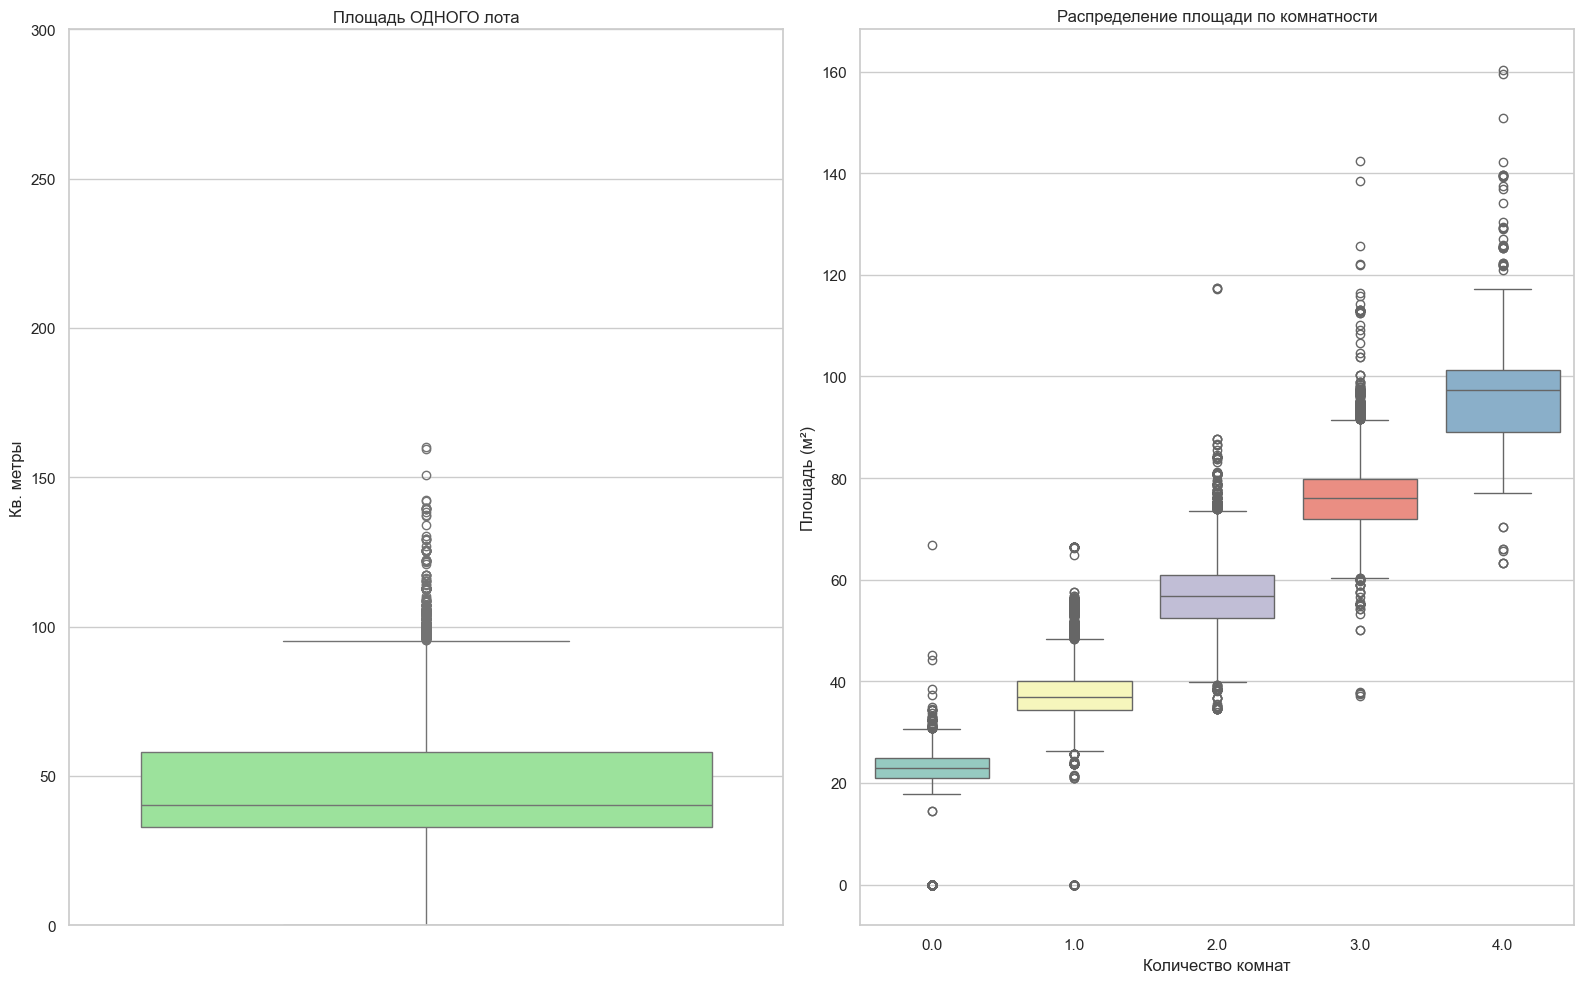

=== ПОДОЗРИТЕЛЬНЫЕ ПЛОЩАДИ ===
Объектов < 15 м²: 838 шт.
       Название ЖК  Тип лота  Unit_Area
683   Smart Garden  квартира       0.00
702   Smart Garden  квартира       0.00
791  Дзен-кварталы  квартира       0.00
Объектов > 250 м²: 0 шт.


In [54]:
fig, ax = plt.subplots(1, 2, figsize=(16, 10))

# График 1: Площадь одного лота
sns.boxplot(y=sdel_expanded['Unit_Area'], ax=ax[0], color='lightgreen')
ax[0].set_title('Площадь ОДНОГО лота')
ax[0].set_ylabel('Кв. метры')
ax[0].set_ylim(0, 300) # Фокус на основном массиве, хвост выше 300 обрежется визуально

# График 2: Площадь в разбивке по комнатам
# Здесь x=Комнаты (категории), y=Площадь (значения) -> получаем вертикальные ящики
# Фильтруем редкие значения комнат для красоты
data_rooms = sdel_expanded[(sdel_expanded['Количество комнат'] >= 0) & (sdel_expanded['Количество комнат'] <= 5)]

sns.boxplot(x='Количество комнат', y='Unit_Area', data=data_rooms, ax=ax[1], palette="Set3")
ax[1].set_title('Распределение площади по комнатности')
ax[1].set_ylabel('Площадь (м²)')

plt.tight_layout()
plt.show()

# --- СТАТИСТИКА ПО ВЫБРОСАМ ---
print("=== ПОДОЗРИТЕЛЬНЫЕ ПЛОЩАДИ ===")
# Микро-объекты (< 15 метров)
micro = sdel[sdel['Unit_Area'] < 15]
print(f"Объектов < 15 м²: {micro['Суммарное количество сделок'].sum()} шт.")
if not micro.empty:
    print(micro[['Название ЖК', 'Тип лота', 'Unit_Area']].head(3))

# Гиганты (> 250 метров)
huge = sdel[sdel['Unit_Area'] > 250]
print(f"Объектов > 250 м²: {huge['Суммарное количество сделок'].sum()} шт.")

In [55]:
# 1. Мердж исходных (сгруппированных) данных
df_check = sdel.merge(proj[['ID корпуса', 'Этожей до']], on='ID корпуса', how='left')

# 2. Вычисляем ошибку
df_check['Diff_Floor'] = df_check['Этаж лота'] - df_check['Этожей до']

# 3. Размножаем только для графика (берем строки, где есть ошибка)
# Нам интересны только случаи превышения
errors_df = df_check[df_check['Diff_Floor'] > 0].copy()

if not errors_df.empty:
    # Размножаем
    counts_err = errors_df['Суммарное количество сделок'].fillna(1).astype(int)
    expanded_idx_err = np.repeat(errors_df.index, counts_err)
    errors_expanded = errors_df.loc[expanded_idx_err]
    
    # График
    plt.figure(figsize=(6, 8))
    sns.boxplot(y=errors_expanded['Diff_Floor'], color='orange')
    plt.title('На сколько этажей проданный лот выше крыши')
    plt.ylabel('Этажей превышения')
    plt.show()
    
    print("=== ТОП ОШИБОК ЭТАЖНОСТИ ===")
    print(errors_df[['Название ЖК', 'Этаж лота', 'Этажей до', 'Diff_Floor', 'Суммарное количество сделок']]
          .sort_values(by='Diff_Floor', ascending=False).head(10))
else:
    print("Аномалий с этажностью (выше максимального) не найдено.")

Аномалий с этажностью (выше максимального) не найдено.


In [56]:
import pandas as pd
import numpy as np

# === НАСТРОЙКИ ===
IQR_THRESHOLD = 1.5
MIN_PRICE_UNIT = 1_000_000

# === 0. ПОДГОТОВКА И БЕЗОПАСНОЕ ОБЪЕДИНЕНИЕ (ЧТОБЫ НАЙТИ ДАТУ СТАРТА) ===
sdel_clean = sdel.copy()
proj_clean = proj.copy()

# Названия колонок с датами, которые нам нужны
col_dogovor = 'Дата договора (месяц.год)'
col_reg = 'Дата регистрации (месяц.год)'
col_start = 'Дата начала проекта' # <--- ПРОВЕРЬ, ЧТО В ТАБЛИЦЕ PROJ ОНА НАЗЫВАЕТСЯ ТАК ЖЕ!

# Пытаемся найти дату старта. Если её нет в сделках, тащим из проектов
if col_start not in sdel_clean.columns:
    if col_start in proj_clean.columns:
        # Ищем ключ для объединения (обычно это ID проекта)
        # Пробуем самые частые варианты: 'ID проекта', 'id_project', 'ID_PROJ'
        merge_keys = [k for k in ['ID проекта', 'ID_проекта', 'id_project'] if k in sdel_clean.columns and k in proj_clean.columns]
        
        if merge_keys:
            print(f"✅ Подтягиваем '{col_start}' из таблицы проектов по ключу: {merge_keys[0]}...")
            sdel_clean = sdel_clean.merge(proj_clean[[merge_keys[0], col_start]], on=merge_keys[0], how='left')
        else:
            print(f"⚠️ ВНИМАНИЕ: Не нашел общий ID для объединения таблиц. '{col_start}' может отсутствовать!")
    else:
        print(f"⚠️ ВНИМАНИЕ: Колонки '{col_start}' нет ни в сделках, ни в проектах. Проверь название!")

# === 1. ПРЕДОБРАБОТКА (ETL) ===
def clean_numeric_col(df, col_name):
    if col_name in df.columns:
        val = df[col_name].astype(str)
        val = val.str.replace("\u00a0", "").str.replace(" ", "").str.replace(",", ".")
        return pd.to_numeric(val, errors="coerce").fillna(0)
    return df[col_name] if col_name in df.columns else 0

# Очистка чисел
target_cols = ['Сумма бюджета', 'Суммарная площадь сделок', 'Суммарное количество сделок', 
               'Этаж лота', 'Количество комнат']
for col in target_cols:
    sdel_clean[col] = clean_numeric_col(sdel_clean, col)

# === ОЧИСТКА ДАТ (САМОЕ ВАЖНОЕ) ===
# Собираем все даты, которые есть в датафрейме
all_date_cols = [c for c in [col_dogovor, col_reg, col_start] if c in sdel_clean.columns]

print("\n=== ОТЧЕТ ПО ДАТАМ (ДО ФИЛЬТРАЦИИ) ===")
for col in all_date_cols:
    # 1. Запоминаем сколько было пустых до конвертации
    na_before = sdel_clean[col].isna().sum()
    
    # 2. Конвертируем с dayfirst=True (Российский формат ДД.ММ.ГГГГ)
    # errors='coerce' превратит мусор в NaT, но мы это отследим
    sdel_clean[col] = pd.to_datetime(sdel_clean[col], dayfirst=True, errors='coerce')
    
    # 3. Считаем сколько стало пустых
    na_after = sdel_clean[col].isna().sum()
    lost = na_after - na_before
    
    print(f"Колонка '{col}':")
    if lost > 0:
        print(f"  ❌ БИТЫЙ ФОРМАТ: {lost} значений не удалось прочитать (превратились в NaT).")
    else:
        print(f"  ✅ Все значения успешно распознаны.")

# Расчет удельных метрик
sdel_clean['cnt_safe'] = sdel_clean['Суммарное количество сделок'].replace(0, 1)
sdel_clean['Unit_Area'] = sdel_clean['Суммарная площадь сделок'] / sdel_clean['cnt_safe']
sdel_clean['Unit_Price'] = sdel_clean['Сумма бюджета'] / sdel_clean['cnt_safe']
sdel_clean['Price_m2'] = sdel_clean['Сумма бюджета'] / sdel_clean['Суммарная площадь сделок'].replace(0, np.nan)


# === 2. УМНАЯ ФИЛЬТРАЦИЯ: ПЛОЩАДЬ vs КОМНАТЫ ===
mask_area_rooms_outlier = pd.Series(False, index=sdel_clean.index)
unique_rooms = sorted(sdel_clean['Количество комнат'].unique())

print("\n=== ФИЛЬТРАЦИЯ ПЛОЩАДЕЙ ===")
for room_cnt in unique_rooms:
    idx_room = sdel_clean[sdel_clean['Количество комнат'] == room_cnt].index
    if len(idx_room) == 0: continue
    
    subset_areas = sdel_clean.loc[idx_room, 'Unit_Area']
    Q1 = subset_areas.quantile(0.25)
    Q3 = subset_areas.quantile(0.75)
    IQR = Q3 - Q1
    lower = max(Q1 - (IQR_THRESHOLD * IQR), 10.0)
    upper = Q3 + (IQR_THRESHOLD * IQR)
    
    bad_indices = subset_areas[(subset_areas < lower) | (subset_areas > upper)].index
    mask_area_rooms_outlier.loc[bad_indices] = True

# === 3. ОСТАЛЬНЫЕ ФИЛЬТРЫ ===
Q1_p = sdel_clean['Price_m2'].quantile(0.25)
Q3_p = sdel_clean['Price_m2'].quantile(0.75)
IQR_p = Q3_p - Q1_p
mask_price_outlier = (sdel_clean['Price_m2'] < (Q1_p - 1.5*IQR_p)) | (sdel_clean['Price_m2'] > (Q3_p + 1.5*IQR_p))

mask_cheap = sdel_clean['Unit_Price'] < MIN_PRICE_UNIT

# === 4. СБОРКА ИТОГОВОГО ДАТАСЕТА ===
total_mask = mask_area_rooms_outlier | mask_price_outlier | mask_cheap 
sdel_final = sdel_clean[~total_mask].copy()

# === 5. ФИНАЛЬНЫЙ ОТЧЕТ ===
print("\n" + "="*60)
print(f"ИТОГИ ОЧИСТКИ (Было: {len(sdel_clean)} -> Стало: {len(sdel_final)})")
print("-" * 60)
    
print("-" * 60)
print(f"Удалено строк всего: {total_mask.sum()}")
sdel_final.drop(columns=['cnt_safe'], inplace=True, errors='ignore')

⚠️ ВНИМАНИЕ: Колонки 'Дата начала проекта' нет ни в сделках, ни в проектах. Проверь название!

=== ОТЧЕТ ПО ДАТАМ (ДО ФИЛЬТРАЦИИ) ===
Колонка 'Дата договора (месяц.год)':
  ✅ Все значения успешно распознаны.
Колонка 'Дата регистрации (месяц.год)':
  ✅ Все значения успешно распознаны.

=== ФИЛЬТРАЦИЯ ПЛОЩАДЕЙ ===

ИТОГИ ОЧИСТКИ (Было: 50955 -> Стало: 47983)
------------------------------------------------------------
------------------------------------------------------------
Удалено строк всего: 2972
